In [5]:
import sys
import os

# Add the parent directory to the Python path
parent_dir = os.path.abspath('../..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
# Import modules
import ddsp_textures.auxiliar.filterbanks
import ddsp_textures.auxiliar.seeds
import ddsp_textures.auxiliar.configuration
import ddsp_textures.auxiliar.features

# Import extra modules
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch
from torch.utils.data import DataLoader, Dataset

og audio


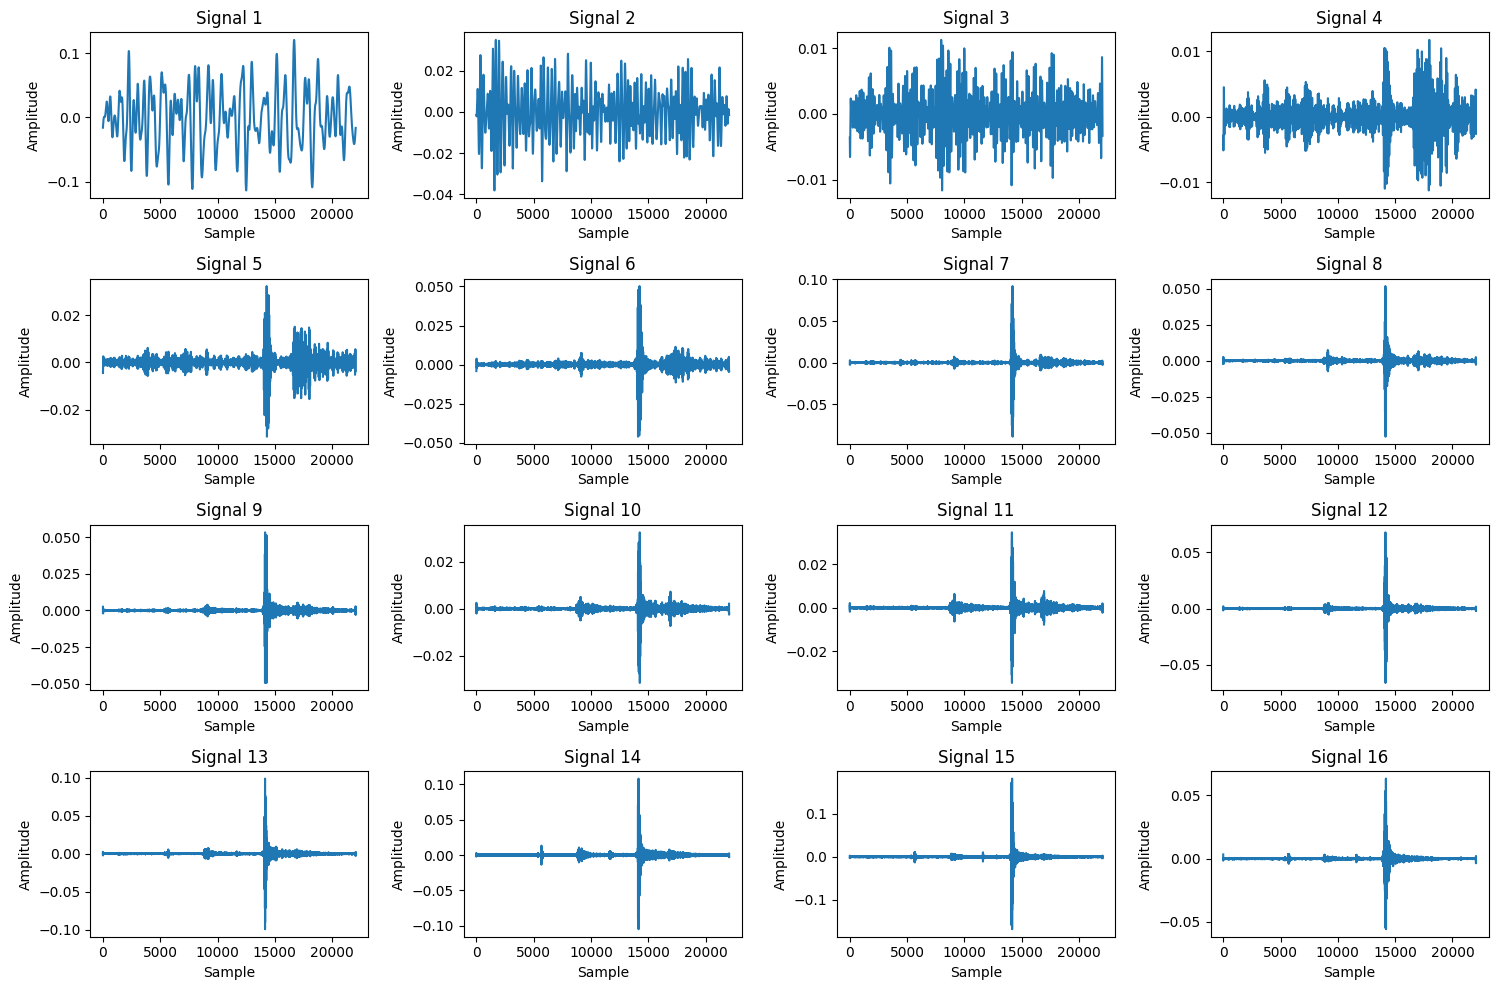

Playing subband 1


Playing subband 2


Playing subband 3


Playing subband 4


Playing subband 5


Playing subband 6


Playing subband 7


Playing subband 8


Playing subband 9


Playing subband 10


Playing subband 11


Playing subband 12


Playing subband 13


Playing subband 14


Playing subband 15


Playing subband 16


In [6]:
# Use of filterbanks   

# Load audio to filter ---------------
audio_path    = ".."+"/sounds/fire_sounds/fire.wav"
sr = 44100
audio, _ = librosa.load(audio_path, sr=sr)
# Chop audio ------------------------
size = sr // 2
audio = audio[sr*2:sr*2 + size]
print("og audio")
display(Audio(audio, rate=sr))
audio = torch.tensor(audio).float()
# Create filterbank -----------------      
N_filter_bank = 16
erb_bank = ddsp_textures.auxiliar.filterbanks.EqualRectangularBandwidth(size, sr, N_filter_bank, 20, sr // 2)
# log_bank = auxiliar.filterbanks.Logarithmic(size, sr, N_filter_bank, 20, sr // 2)
# lin_bank = auxiliar.filterbanks.Linear(size, sr, N_filter_bank, 20, sr // 2)
# Apply filterbank ------------------
subbands_signal = erb_bank.generate_subbands(audio)[1:-1, :]

def plot_signals(matrix):
    num_signals = matrix.shape[0]
    fig, axes = plt.subplots(4, 4, figsize=(15, 10))
    
    for i in range(num_signals):
        row = i // 4
        col = i % 4
        axes[row, col].plot(matrix[i].detach().cpu().numpy())
        axes[row, col].set_title(f'Signal {i+1}')
        axes[row, col].set_xlabel('Sample')
        axes[row, col].set_ylabel('Amplitude')

    # Hide any unused subplots
    for i in range(num_signals, 16):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

plot_signals(subbands_signal)

for i in range(16):
    # play audio
    print(f"Playing subband {i+1}")
    display(Audio(subbands_signal[:, i].detach().cpu().numpy(), rate=sr))
    

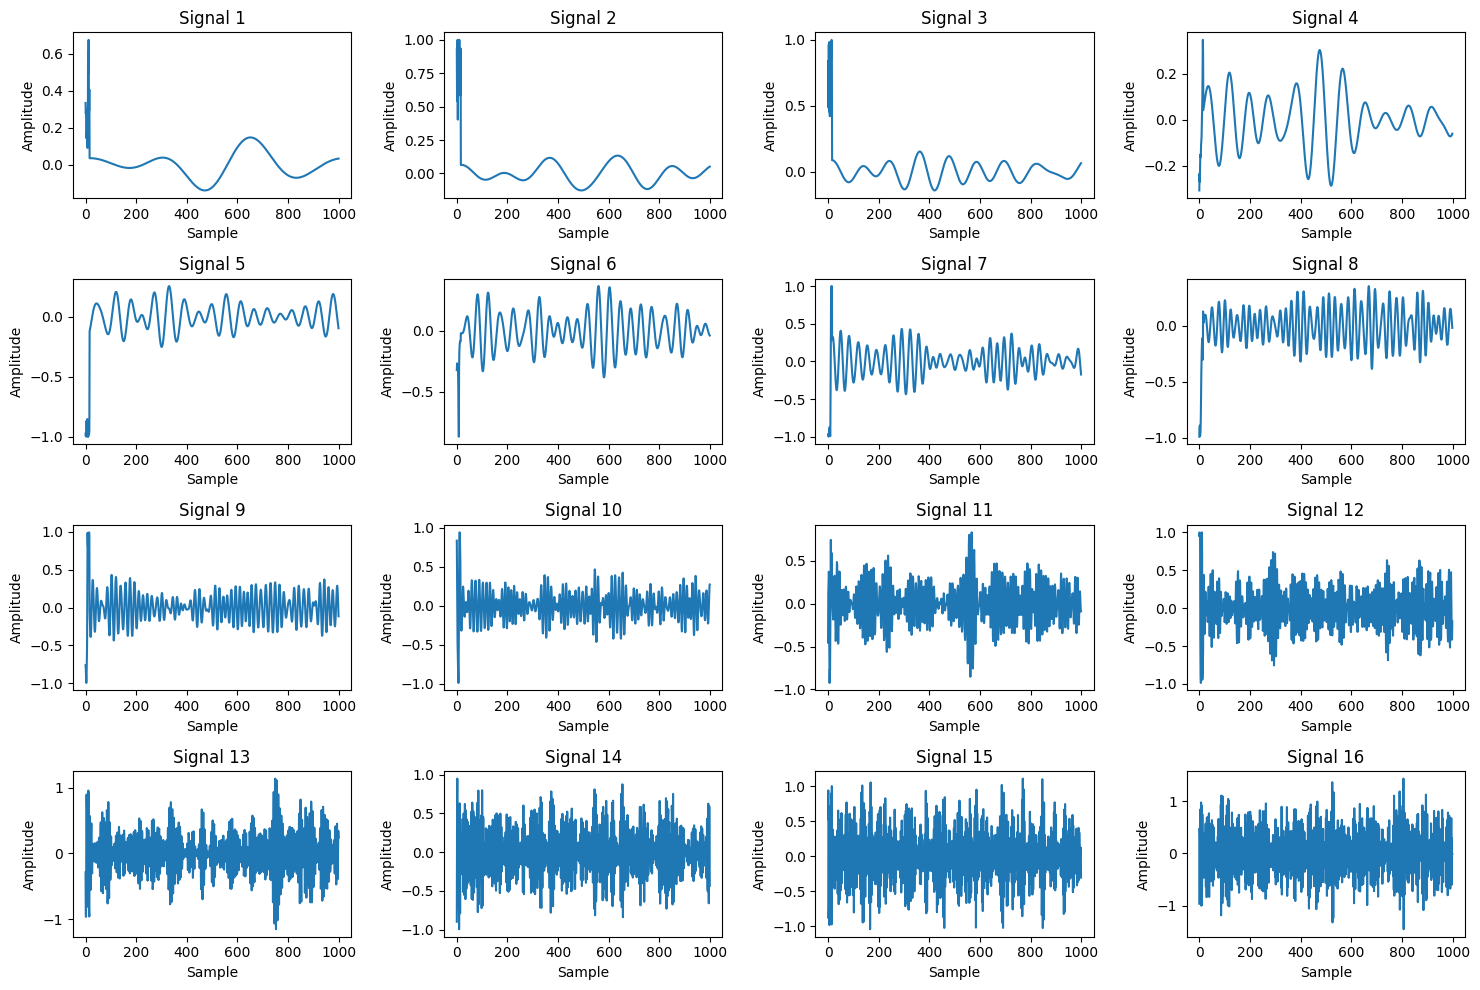

Playing subband 1


Playing subband 2


Playing subband 3


Playing subband 4


Playing subband 5


Playing subband 6


Playing subband 7


Playing subband 8


Playing subband 9


Playing subband 10


Playing subband 11


Playing subband 12


Playing subband 13


Playing subband 14


Playing subband 15


Playing subband 16


In [7]:
# Creation of seeds

seed = ddsp_textures.auxiliar.seeds.seed_maker(1000, 44100, N_filter_bank)
plot_signals(seed)
for i in range(16):
    # play audio
    print(f"Playing subband {i+1}")
    display(Audio(seed[:, i].detach().cpu().numpy(), rate=sr))


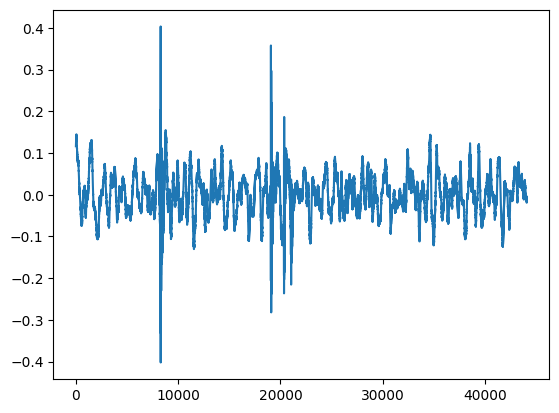

1. Feature using features_freqavg_freqstd
Frequency average: 0.8600071668624878
Frequency standard deviation: 0.8486771583557129


2. Feature using features_freqavg_rate
Frequency average: 0.8600071668624878
Rate: 0.5999561548233032
(Such rate can be interpreted as 2.999780774116516 events in a second)


In [25]:
# Feature computation

# Load audio to filter -----------------------------------
audio_path    = ".."+"/sounds/fire_sounds/fire.wav"
sr = 44100
audio, _ = librosa.load(audio_path, sr=sr)
import numpy as np
lol = np.random.randint(0, len(audio) - sr)
segment  = audio[lol:lol+ sr]
#plot segment
plt.plot(segment)
plt.show()
#play segment
display(Audio(segment, rate=sr))
#numpy to tensor
segment = torch.tensor(segment).float()

# Feature computation for a single segment ----------------
print("1. Feature using features_freqavg_freqstd")
freqavg, freqstd = ddsp_textures.auxiliar.features.features_freqavg_freqstd(segment, sr, _)
print(f"Frequency average: {freqavg}")
print(f"Frequency standard deviation: {freqstd}")
print("\n")
print("2. Feature using features_freqavg_rate")
rate    = ddsp_textures.auxiliar.features.features_rate(segment, sr, _)
print(f"Frequency average: {freqavg}")
print(f"Rate: {rate}")
print("(Such rate can be interpreted as "+str(float(rate)*5)+" events in a second)")


In [30]:
# Feature computation in batches
import torch
from torch.utils.data import DataLoader, Dataset
import librosa

# Load audio to filter -----------------------------------
audio_path = "../sounds/fire_sounds/fire.wav"
sr = 44100
audio, _ = librosa.load(audio_path, sr=sr)

# Create a custom dataset for audio segments
class AudioSegmentDataset(Dataset):
    def __init__(self, audio, segment_length, max_segments):
        self.audio = audio
        self.segment_length = segment_length
        self.segments = self._create_segments(max_segments)

    def _create_segments(self, max_segments):
        segments = []
        total_segments = (len(self.audio) - self.segment_length) // self.segment_length + 1
        max_segments = min(max_segments, total_segments)
        for i in range(max_segments):
            start = i * self.segment_length
            end = start + self.segment_length
            segment = self.audio[start:end]
            segments.append(segment)
        return segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return torch.tensor(self.segments[idx], dtype=torch.float32)

# Define segment length (e.g., 1 second of audio)
segment_length = sr  # 1 second

# Set the maximum number of segments to be used in the dataset
max_segments = 10  # Adjust this value as needed

# Create the dataset
dataset = AudioSegmentDataset(audio, segment_length, max_segments)

# Create a DataLoader for batching
batch_size = 2  # Adjust as needed
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Compute features for batches
i=0
for batch in dataloader:
    # Assuming batch is of shape (batch_size, segment_length)
    mean_std_features  = ddsp_textures.auxiliar.features.batch_features_freqavg_freqstd(batch, sr, _)
    freq_rate_features = ddsp_textures.auxiliar.features.batch_features_rate(batch, sr, _)
    
    # Print or process the results as needed
    print("Batch number: ", i)
    print("Mean and Std Dev features: ", mean_std_features)
    print("Rate features:", freq_rate_features, "\n")
    i+=1

Batch number:  0
Mean and Std Dev features:  tensor([[0.8419, 0.8568],
        [0.7602, 0.8352]])
Rate features: tensor([0.6000, 1.3622]) 

Batch number:  1
Mean and Std Dev features:  tensor([[0.8320, 0.8479],
        [0.8145, 0.8454]])
Rate features: tensor([0.2000, 0.8372]) 

Batch number:  2
Mean and Std Dev features:  tensor([[0.7948, 0.8371],
        [0.7783, 0.8310]])
Rate features: tensor([0.2000, 0.5750]) 

Batch number:  3
Mean and Std Dev features:  tensor([[0.8416, 0.8603],
        [0.8216, 0.8421]])
Rate features: tensor([0.4004, 0.4004]) 

Batch number:  4
Mean and Std Dev features:  tensor([[0.7588, 0.8284],
        [0.8780, 0.8615]])
Rate features: tensor([3.2830, 0.4000]) 



/home/esteban/projects/ddsp_textures/current/ddsp_textures/auxiliar/features.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(rate)


In [35]:
# Use of configuration

json_file_path = "config_template_subenv.json"
parameters = ddsp_textures.auxiliar.configuration.model_json_to_parameters(json_file_path)

for key, value in parameters.items():
    print(f"{key}: {value}")

audio_path: ../sounds/fire_short.wav
frame_size: 32768
hop_size: 16384
sampling_rate: 44100
features: [<function features_freqavg at 0x7f128efc12d0>, <function features_freqavg_freqstd at 0x7f128efc1360>, <function features_rate at 0x7f128efc13f0>, <function features_energy_bands at 0x7f128efc1480>, <function features_envelopes_stems at 0x7f128efc1510>, 1, 2, 1, 16, 16, 32768]
input_dimensions: []
hidden_size_enc: 512
hidden_size_dec: 512
deepness_enc: 3
deepness_dec: 3
param_per_env: 512
N_filter_bank: 16
M_filter_bank: 16
architecture: <class 'ddsp_textures.architectures.DDSP.DDSP_SubEnv'>
stems: True
loss_function: <function batch_statistics_loss at 0x7f128efc1f30>
regularizer: [<function batch_features_rate at 0x7f128efc16c0>, <function batch_features_energy_bands at 0x7f128efc1750>]
batch_size: 16
epochs: 2
models_directory: ../trained_models


In [39]:
# Checking if the name of the trained models folders work

# Assuming there is nothing in the folder trained_models this should print model_01
print(ddsp_textures.auxiliar.configuration.get_next_model_folder("../trained_models/"))
# Create folder model_01 in "../trained_models/"
os.makedirs("../trained_models/model_01")
# Assuming there is a folder model_01 in the folder trained_models this should print model_02
print(ddsp_textures.auxiliar.configuration.get_next_model_folder("../trained_models/"))
# Delete the folder created
os.rmdir("../trained_models/model_01")

model_01
model_02


In [ ]:
# import librosa
# import librosa.display
# import matplotlib.pyplot as plt
# import numpy as np
# from IPython.display import Audio

# sr = 44100

# # Load an example audio file
# y, sr = librosa.load("../sounds/fire.wav", sr=sr)

# # random integer from 0 to 60
# random_integer = np.random.randint(0, 60)

# # Extract a 2-second segment
# y = y[sr*random_integer:sr*(random_integer+2)]

# # play the segment
# display(Audio(y, rate=sr))

# hop_length = 2048

# # print the size of the onset_envelope given the hop length and sr
# print(sr * 2 // hop_length + 1)

# # Get the frame->beat strength profile
# onset_envelope = librosa.onset.onset_strength(y=y,
#                                               sr=sr,
#                                               hop_length=hop_length,
#                                               aggregate=np.median)

# def sigmooid(x):
#     return 1 / (1 + np.exp(-x))

# def ReLu(x):
#     return np.maximum(0, x)

# onset = (onset_envelope - np.min(onset_envelope)) / (np.max(onset_envelope) - np.min(onset_envelope)) - 0.5
# onset = sigmooid(onset * 100)
# onset_shifted = np.roll(onset, 1)
# onset_derivative = onset - onset_shifted
# onset_peaks = ReLu(onset_derivative)

# plt.plot(onset_envelope)
# plt.show()

# # plt.plot(onset_derivative) 
# # plt.show()

# plt.plot(onset_peaks) 
# plt.show()

# print(np.sum(onset_peaks))

In [ ]:
# import torch
# import torchaudio
# import matplotlib.pyplot as plt

# def compute_spectrogram(waveform, n_fft=1024, hop_length=512):
#     """
#     Compute the spectrogram from the waveform.

#     Parameters:
#         waveform (torch.Tensor): Input audio waveform tensor.
#         n_fft (int): Number of FFT points.
#         hop_length (int): Number of samples between frames.

#     Returns:
#         torch.Tensor: Spectrogram magnitude.
#     """
#     spectrogram = torch.stft(waveform, n_fft=n_fft, hop_length=hop_length, return_complex=True, window=torch.hann_window(n_fft))
#     magnitude = torch.abs(spectrogram)
#     return magnitude

# def calculate_onset_strength(spectrogram):
#     """
#     Calculate the onset strength from the spectrogram.

#     Parameters:
#         spectrogram (torch.Tensor): Input spectrogram tensor.

#     Returns:
#         torch.Tensor: Onset strength.
#     """
#     # Calculate the difference between consecutive frames (along the time axis)
#     diff_spectrogram = spectrogram[:, 1:] - spectrogram[:, :-1]
    
#     # Apply ReLU to keep only positive differences
#     onset_strength = torch.relu(diff_spectrogram)
    
#     # Average across frequency bins (dim=0)
#     onset_strength_mean = torch.mean(onset_strength, dim=0)
    
#     # Prepend a zero at the start to match the original number of frames
#     onset_strength_mean = torch.cat((torch.zeros(1), onset_strength_mean), dim=0)
    
#     return onset_strength_mean

# def compute_onset_peaks(onset_strength):
#     """
#     Compute the onset peaks from the onset strength.

#     Parameters:
#         onset_strength (np.ndarray): Input onset strength array.

#     Returns:
#         np.ndarray: Onset peaks.
#     """
#     # Normalize onset strength
#     onset_strength = (onset_strength - torch.min(onset_strength)) / (torch.max(onset_strength) - torch.min(onset_strength)) - 0.5
    
#     # Apply sigmoid function
#     onset = torch.sigmoid(onset_strength * 100)
    
#     # Compute the derivative and apply ReLU
#     onset_shifted = np.roll(onset, 1)
#     onset_derivative = onset - onset_shifted
#     onset_peaks = np.maximum(onset_derivative, 0)
    
#     return onset_peaks

# def computer_rate(signal_tensor, sampling_rate):
#     spectrogram = compute_spectrogram(signal_tensor)
#     onset_strength = calculate_onset_strength(spectrogram)
#     plt.plot(onset_strength)
#     plt.show()
#     onset_peaks = compute_onset_peaks(onset_strength)
#     plt.plot(onset_peaks)
#     plt.show()
#     rate = torch.sum(onset_peaks)
#     print(rate)
#     return rate

# waveform = torch.tensor(y).unsqueeze(0)

# computer_rate(waveform[0], sr)